In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, ttest_rel, pearsonr
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Get data on Currency Changes from Yahoo Finance for 5 years
#currency_data = yf.Ticker("EURUSD=X")
#df_currency = currency_data.history(period="5y")

# Export the data to a csv file 
#path = '../Data/eur_usd_exchange_rate.csv'
#df_currency.to_csv(path)

# Read data from csv files
lor_df = pd.read_csv('../Data/loreal_stock_price.csv')
est_df = pd.read_csv('../Data/estee_stock_price.csv')
uni_df = pd.read_csv('../Data/unilever_stock_price.csv')
currency_df = pd.read_csv('../Data/eur_usd_exchange_rate.csv')

In [3]:
# Preprocessing data

# Convert to datetime
lor_df['Date'] = pd.to_datetime(lor_df['Date'], errors='coerce', utc = True)
est_df['Date'] = pd.to_datetime(est_df['Date'], errors='coerce', utc = True)
uni_df['Date'] = pd.to_datetime(uni_df['Date'], errors='coerce', utc = True)

currency_df['Date'] = pd.to_datetime(currency_df['Date'], errors='coerce', utc=True)

# Remove invalid Date
lor_df = lor_df.dropna(subset=['Date'])
est_df = est_df.dropna(subset=['Date'])
uni_df = uni_df.dropna(subset=['Date'])

currency_df = currency_df.dropna(subset=['Date'])

# Consider only date part
lor_df['Date'] = lor_df['Date'].dt.date
est_df['Date'] = est_df['Date'].dt.date
uni_df['Date'] = uni_df['Date'].dt.date

currency_df['Date'] = currency_df['Date'].dt.date

# Merge stock price and currency changes
merged_lor_df = pd.merge(lor_df, currency_df, on='Date', how='inner')
merged_est_df = pd.merge(est_df, currency_df, on='Date', how='inner')
merged_uni_df = pd.merge(uni_df, currency_df, on='Date', how='inner')

merged_lor_df = merged_lor_df[['Date', 'Close_x', 'Close_y']]
merged_est_df = merged_est_df[['Date', 'Close_x', 'Close_y']]
merged_uni_df = merged_uni_df[['Date', 'Close_x', 'Close_y']]

merged_lor_df.columns = ['Date', 'Loreal_Stock', 'Close_currency']
merged_est_df.columns = ['Date', 'Estee_Lauder_Stock', 'Close_currency']
merged_uni_df.columns = ['Date', 'Unilever_Stock', 'Close_currency']

# ANOVA to determine the correlation between close stock price(dependent) and currency exchange rate(independent)
print('Correlation between Loreal stock price and currency exchange rate')
model = ols('Loreal_Stock ~ C(Close_currency)', data=merged_lor_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
correlation = merged_lor_df[['Loreal_Stock', 'Close_currency']].corr().iloc[0, 1]
print(anova_table)
print(f"R: {correlation:.4f}")

print('Correlation between Estee Lauder stock price and currency exchange rate')
model = ols('Estee_Lauder_Stock ~ C(Close_currency)', data=merged_est_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
correlation = merged_est_df[['Estee_Lauder_Stock', 'Close_currency']].corr().iloc[0, 1]
print(anova_table)
print(f"R: {correlation:.4f}")

print('Correlation between Unilever stock price and currency exchange rate')
model = ols('Unilever_Stock ~ C(Close_currency)', data=merged_uni_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
correlation = merged_uni_df[['Unilever_Stock', 'Close_currency']].corr().iloc[0, 1]
print(anova_table)
print(f"R: {correlation:.4f}")


Correlation between Loreal stock price and currency exchange rate
                         sum_sq      df         F    PR(>F)
C(Close_currency)  4.516436e+06  1093.0  1.456446  0.017268
Residual           2.241343e+05    79.0       NaN       NaN
R: -0.2276
Correlation between Estee Lauder stock price and currency exchange rate
                         sum_sq      df        F   PR(>F)
C(Close_currency)  4.822312e+06  1034.0  1.82805  0.00063
Residual           1.913410e+05    75.0      NaN      NaN
R: 0.3990
Correlation between Unilever stock price and currency exchange rate
                         sum_sq      df         F    PR(>F)
C(Close_currency)  24602.738672  1034.0  1.155655  0.215286
Residual            1544.172422    75.0       NaN       NaN
R: 0.3915


# Result breakdown

### Among L'oreal, Estee Lauder and Unilever

        • L'oréal: Shows a weak negative correlation(R=0.2276) with currency exchange rates, with a statistically significant p-value( p=0.017268 < 0.05).

        • Estee Lauder: Exhibits a moderate positive correlation(R=0.3990) with currency exchange rates, with a highly significant p-value(p=0.00063 < 0.05).

        • Unilever: Displays a moderate positive correlation(R=0.3915), but the p-value suggests that this correlation is not statistically significant(p=0.215286 > 0.05).

   *Conclusion: L'Oréal appears to be the most stable among the three companies, given its weak negative correlation with currency exchange rates and statistical significance. Estee Lauder and Unilever also show stability, but their stock prices are more influenced by currency exchange rates.*

### L'oreal - the most stable

**Sum of Squares:** The SS of Close_currency(about 4,500,000) is much larger than the SS of Residual(about 220,000), which means that the there is a significant portion of the variability in the data, indicating a good fit with relatively small prediction errors.

**F-Stat:** The quite low F value(1.456) suggests that the model's explanatory power is limited. However, it is necessary to consider both F-value and p-value as p-value is crucial for determining statistical significance.

**Significance of the Factor:** The p-value is less than 0.05, suggesting that there is a low probability that the relationship between stock price and currency exchange rate is due to random chance. It gives us confidence to say that the relationship observed in the sample likely exists in the population.

**Negative correlation:** Calculating R-value reveals a week negative correlation of -0.2276, indicating that as one variable increases, the other tends to decrease slightly. Although this negative correlation might seem unusual, it can be explain by how exchange rates impact the competitiveness and profitability of European companies. In detail, when the rate decreases(Euro depreciates against the USD), European exports become cheaper for consumers and businesses in USD-using countries. This increases the competitiveness of European companies in the international market, potentially boosting their sales and profits, leading to a subtle increase in their stock price.

***In conclusion, based on the ANOVA result, we can state that the currency exchange rate have a statistically significant but weak effect on Loreal's stock price***

# Loreal - the most stable

## Scatter Plot


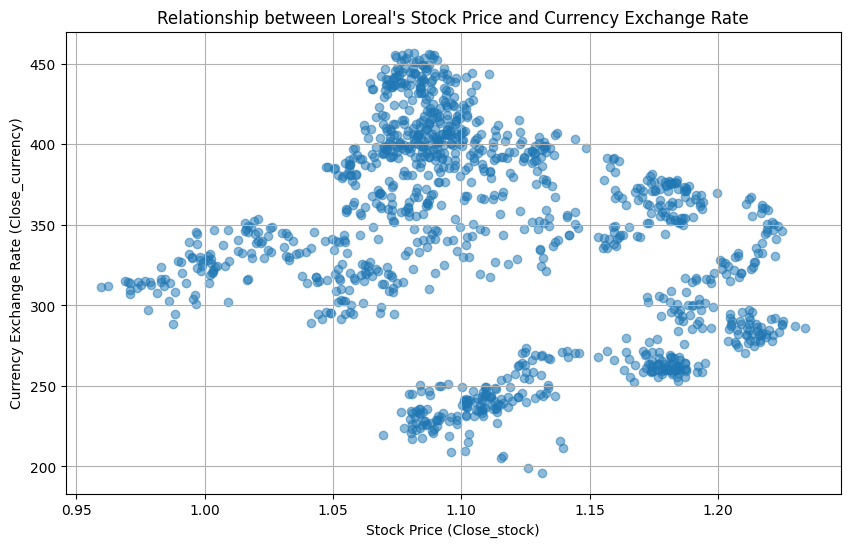

In [4]:
# Plot the relationship between stock price (Close_x) and currency exchange rate (Close_y)
plt.figure(figsize=(10, 6))
plt.scatter(merged_lor_df['Close_currency'], merged_lor_df['Loreal_Stock'], alpha=0.5)
plt.title("Relationship between Loreal's Stock Price and Currency Exchange Rate")
plt.xlabel('Stock Price (Close_stock)')
plt.ylabel('Currency Exchange Rate (Close_currency)')
plt.grid(True)
plt.show()

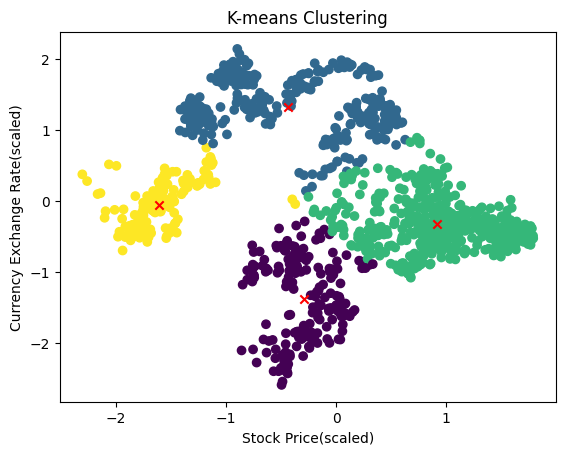

In [5]:
# K-Means

data = merged_lor_df[['Loreal_Stock', 'Close_currency']].values

# Standardize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# KMeans algorithm with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(data_scaled)
labels = kmeans.predict(data_scaled)
centroids = kmeans.cluster_centers_

# Plot k-means clustering
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')
plt.xlabel('Stock Price(scaled)')
plt.ylabel('Currency Exchange Rate(scaled)')
plt.title('K-means Clustering')
plt.show()

### Result breakdown

This K-Means clustering algorithm has grouped the data points into four clusters with four different colors. This suggests that there are different patterns in the relationship. 

*The yellow cluster* is centered around lower stock prices and a narrow range of exchange rates, representing a stable period with specific economic conditions.

*The blue and green clusters* cover higher ranges of stock prices and are spread more widely in exchange rate values, indicating more volatility or variation in currency exchange rates during these periods.

*The purple cluster* is concentrated at lower stock prices with varying exchange rates, possibly representing a period of reduced stock market performance or lower economic stability.

***In conclusion, the scatter plot and k-means plot might show a lot of variability and not clearly reflect the negative correlation due to the weak relationship with currency exchange rate and the influence of many factors, especially business indices.***